In [1]:
import importlib
import os
import numpy as np
import numpy.random as npr
import math
import scipy.sparse as scipy_sparse

import matplotlib.pyplot as plt
%matplotlib inline

import constants
if constants.venv_sites_path is not None:
    import site
    site.addsitedir(constants.venv_sites_path)
    
import sparse

# sampling synthetic data

In [2]:
%%time

sampler = npr.RandomState(seed=0)

# binary synthetic data
# synthetic data is generated directly in terms of features and labels, and not the timeseries. It is easier to control the setting of depdency noises by sampling labels and then dimensions in the features

# number of samples
n = 10000
# marginal distribution for each dimension is same
p = 0.5

# number of ones and zeros
labels = np.zeros(n, dtype=np.bool)
num_ones = int(p*n)
num_zeros = n - num_ones

# sampling labels
ones_idx = sampler.choice(n, num_ones, replace=False)
labels[ones_idx] = True
zeros_idx = np.where(~labels)[0]

# number of features is time lag, though we never generate the actual timeseries but only the corresponding features and labels,
# as representative samples of the relevant random variables
features_dim = 20

# dependency between feature dimensions and label is introduced by choosing a different probability of sampling ones than it is for the marginal
# we effectively generate 50 timeseries, with dependence of all of them varying w.r.t. a single timeseries as per the value of q.
# lower value of q corresponds to higher dependence since it varies more w.r.t. the marginal probability of 0.5. 
q_vals = np.arange(0.5, 0.0, -0.01)
num_time_series = q_vals.size

# marginal entropy for labels is simple to compute
Hy = -p*math.log(p) - (1.0-p)*math.log(1.0-p)

# features initialization (binary format for memory savings)
time_series_features = np.zeros((num_time_series, n, features_dim), dtype=np.bool)

# entropy of features
Hx = np.zeros(num_time_series, dtype=np.float)
# conditional entropy of features given the labels
Hx_y = np.zeros(num_time_series, dtype=np.float)

for curr_timeseries_idx, q in enumerate(q_vals):
    
    print(q, end=',')

    # conditional sampling of ones and zero with probability q     
    # marginal probability of the feature remains p
    num_ones_in_feature_for_one_labels = int(q*num_ones)
    num_ones_in_feature_for_zero_labels = int((1.0-q)*num_zeros)
    num_ones_in_feature = (num_ones_in_feature_for_one_labels+num_ones_in_feature_for_zero_labels)
    
    frac_ones = float(num_ones_in_feature)/n    
    Hx[curr_timeseries_idx] = -frac_ones*math.log(frac_ones) -(1.0-frac_ones)*math.log(1.0-frac_ones)
    Hx_y[curr_timeseries_idx] = -q*math.log(q) -(1.0-q)*math.log(1.0-q)
    frac_ones = None
    
    
    
    # only one of the feature dimension is dependent w.r.t. labels while the rest of those are sampled independent of noise
    # and the strength of dependence varies w.r.t. q
    sel_non_noisy_feature = sampler.choice(features_dim)
    
    for curr_feature_idx in range(features_dim):
        
        if curr_feature_idx == sel_non_noisy_feature:
            
            # sample for the dependent feature dimension (long ranged dependency)
            
            ones_idx_for_feature = sampler.choice(
                num_ones,
                num_ones_in_feature_for_one_labels,
                replace=False,
            )
            
            time_series_features[curr_timeseries_idx, ones_idx[ones_idx_for_feature], curr_feature_idx] = True
            ones_idx_for_feature = None

            zeros_noisy_idx = sampler.choice(
                num_zeros,
                num_ones_in_feature_for_zero_labels,
                replace=False
            )
            time_series_features[curr_timeseries_idx, zeros_idx[zeros_noisy_idx], curr_feature_idx] = True
            zeros_noisy_idx = None            
        else:
            # sample feature dimension independent of labels             
            rnd_idx_for_feature = sampler.choice(
                n,
                num_ones_in_feature,
                replace=False,
            )
            time_series_features[curr_timeseries_idx, rnd_idx_for_feature, curr_feature_idx] = True
            rnd_idx_for_feature = None

# estimate conditional entropy of labels given the features (Bayes)
Hy_x = Hy-Hx+Hx_y
# estimate transfer entropy (CE w.r.t. self is same as marginal entropy, uncertaintly is reduced only from another timeseries)
te = (-Hy_x+Hy_x[0])

0.5,0.49,0.48,0.47,0.45999999999999996,0.44999999999999996,0.43999999999999995,0.42999999999999994,0.41999999999999993,0.4099999999999999,0.3999999999999999,0.3899999999999999,0.3799999999999999,0.3699999999999999,0.3599999999999999,0.34999999999999987,0.33999999999999986,0.32999999999999985,0.31999999999999984,0.30999999999999983,0.2999999999999998,0.2899999999999998,0.2799999999999998,0.2699999999999998,0.2599999999999998,0.24999999999999978,0.23999999999999977,0.22999999999999976,0.21999999999999975,0.20999999999999974,0.19999999999999973,0.18999999999999972,0.17999999999999972,0.1699999999999997,0.1599999999999997,0.1499999999999997,0.13999999999999968,0.12999999999999967,0.11999999999999966,0.10999999999999965,0.09999999999999964,0.08999999999999964,0.07999999999999963,0.06999999999999962,0.05999999999999961,0.0499999999999996,0.03999999999999959,0.029999999999999583,0.019999999999999574,0.009999999999999565,CPU times: user 189 ms, sys: 8.86 ms, total: 198 ms
Wall time: 191 ms


In [3]:
%%time

time_series_features = time_series_features.astype(np.float)
# add very small noise to ensure uniqueness of samples
features_noise = npr.RandomState(seed=0).uniform(size=time_series_features.shape)
# only 20% of the features are noised
features_noise[(features_noise < 0.5)] = 0.0
# keep it super small
features_noise *= 1e-100
time_series_features += features_noise
features_noise = None

sparse_features = sparse.COO.from_numpy(time_series_features)
sparse_labels = scipy_sparse.csr_matrix(labels[:, None].T)
sparse_features.shape, sparse_labels.shape

CPU times: user 673 ms, sys: 206 ms, total: 879 ms
Wall time: 886 ms


((50, 10000, 20), (1, 10000))

In [4]:
dir_path_for_saving_hash_models=f'/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n{n}k{features_dim}t{num_time_series}'
if not os.path.exists(dir_path_for_saving_hash_models):
    print(f'Creating dir {dir_path_for_saving_hash_models}')
    os.mkdir(dir_path_for_saving_hash_models)

/ms/dist/python/PROJ/numba/0.50.1-py37/lib/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'FileNotFoundError([Errno 2] No such file or directory: '/ms/dist/python/PROJ/numpy/1.19.1-ms1-py37/lib/numpy-1.19.1.dist-info/METADATA')'.
  entrypoints.init_all()


(10000, 20)
alpha 32
......................................................................
curr_set_idx 0
alpha: 32
subset_size=32
elements_in_division 8
KL-D scores 35 min:-0.37 max:0.22 mean:-0.09 std:0.13 0.01s
opt split: 4, 4
elements_in_division 8
KL-D scores 35 min:-0.28 max:0.18 mean:-0.06 std:0.09 0.01s
opt split: 4, 4
elements_in_division 8
KL-D scores 35 min:-0.16 max:0.22 mean:-0.05 std:0.08 0.01s
opt split: 4, 4
elements_in_division 8
KL-D scores 35 min:-0.27 max:0.2 mean:-0.08 std:0.12 0.01s
opt split: 4, 4
elements_in_division 32
num_combinations 35
Hz: 0.68, Hz_C: 0.0, KL_sel_cluster: 0.0, KL_C: 0.0, score: 0.68
Hz: 0.69, Hz_C: 0.0, KL_sel_cluster: 0.0, KL_C: 0.0, score: 0.69
Hz: 0.69, Hz_C: 0.0, KL_sel_cluster: 0.0, KL_C: 0.0, score: 0.69
Hz: 0.69, Hz_C: 0.0, KL_sel_cluster: 0.0, KL_C: 0.0, score: 0.69
Hz: 0.69, Hz_C: 0.0, KL_sel_cluster: 0.0, KL_C: 0.0, score: 0.69
Hz: 0.68, Hz_C: 0.0, KL_sel_cluster: 0.0, KL_C: 0.0, score: 0.68
Hz: 0.68, Hz_C: 0.0, KL_sel_cluster: 0.

Hz: 0.69, Hz_C: 0.69, KL_sel_cluster: 0.0, KL_C: 0, score: 1.38
Hz: 0.69, Hz_C: 0.69, KL_sel_cluster: 0.0, KL_C: 0, score: 1.38
Hz: 0.69, Hz_C: 0.68, KL_sel_cluster: 0.0, KL_C: 0, score: 1.37
Hz: 0.67, Hz_C: 0.67, KL_sel_cluster: 0.0, KL_C: 0, score: 1.34
Hz: 0.65, Hz_C: 0.63, KL_sel_cluster: 0.0, KL_C: 0, score: 1.28
Hz: 0.69, Hz_C: 0.67, KL_sel_cluster: 0.0, KL_C: 0, score: 1.36
Hz: 0.67, Hz_C: 0.67, KL_sel_cluster: 0.0, KL_C: 0, score: 1.34
Hz: 0.68, Hz_C: 0.67, KL_sel_cluster: 0.0, KL_C: 0, score: 1.36
Hz: 0.69, Hz_C: 0.69, KL_sel_cluster: 0.0, KL_C: 0, score: 1.38
Hz: 0.69, Hz_C: 0.69, KL_sel_cluster: 0.0, KL_C: 0, score: 1.38
Hz: 0.69, Hz_C: 0.68, KL_sel_cluster: 0.0, KL_C: 0, score: 1.37
Hz: 0.69, Hz_C: 0.69, KL_sel_cluster: 0.0, KL_C: 0, score: 1.38
Hz: 0.69, Hz_C: 0.69, KL_sel_cluster: 0.0, KL_C: 0, score: 1.38
Hz: 0.65, Hz_C: 0.64, KL_sel_cluster: 0.0, KL_C: 0, score: 1.29
Hz: 0.69, Hz_C: 0.68, KL_sel_cluster: 0.0, KL_C: 0, score: 1.37
Hz: 0.69, Hz_C: 0.69, KL_sel_cluster: 0.

Hz: 0.69, Hz_C: 0.68, KL_sel_cluster: 0.0, KL_C: 0, score: 1.37
Hz: 0.64, Hz_C: 0.6, KL_sel_cluster: 0.0, KL_C: 0, score: 1.24
Hz: 0.67, Hz_C: 0.65, KL_sel_cluster: 0.0, KL_C: 0, score: 1.33
Hz: 0.69, Hz_C: 0.65, KL_sel_cluster: 0.0, KL_C: 0, score: 1.34
Hz: 0.68, Hz_C: 0.67, KL_sel_cluster: 0.0, KL_C: 0, score: 1.35
Hz: 0.68, Hz_C: 0.55, KL_sel_cluster: 0.0, KL_C: 0, score: 1.23
Hz: 0.67, Hz_C: 0.44, KL_sel_cluster: 0.0, KL_C: 0, score: 1.11
Hz: 0.69, Hz_C: 0.69, KL_sel_cluster: 0.0, KL_C: 0, score: 1.38
Hz: 0.67, Hz_C: 0.62, KL_sel_cluster: 0.0, KL_C: 0, score: 1.3
Hz: 0.69, Hz_C: 0.64, KL_sel_cluster: 0.0, KL_C: 0, score: 1.33
Hz: 0.68, Hz_C: 0.58, KL_sel_cluster: 0.0, KL_C: 0, score: 1.26
Hz: 0.65, Hz_C: 0.58, KL_sel_cluster: 0.0, KL_C: 0, score: 1.23
Hz: 0.69, Hz_C: 0.63, KL_sel_cluster: 0.0, KL_C: 0, score: 1.32
Hz: 0.69, Hz_C: 0.61, KL_sel_cluster: 0.0, KL_C: 0, score: 1.3
Hz: 0.69, Hz_C: 0.51, KL_sel_cluster: 0.0, KL_C: 0, score: 1.2
Hz: 0.69, Hz_C: 0.68, KL_sel_cluster: 0.0, K

Hz: 0.57, Hz_C: 0.46, KL_sel_cluster: 0.21, KL_C: 0.09, score: 1.33
Hz: 0.57, Hz_C: 0.49, KL_sel_cluster: 0.19, KL_C: 0.07, score: 1.33
Hz: 0.66, Hz_C: 0.63, KL_sel_cluster: 0.25, KL_C: 0.19, score: 1.73
Hz: 0.68, Hz_C: 0.63, KL_sel_cluster: 0.23, KL_C: 0.18, score: 1.72
Hz: 0.66, Hz_C: 0.57, KL_sel_cluster: 0.27, KL_C: 0.16, score: 1.65
Hz: 0.63, Hz_C: 0.55, KL_sel_cluster: 0.23, KL_C: 0.13, score: 1.54
Hz: 0.5, Hz_C: 0.41, KL_sel_cluster: 0.2, KL_C: 0.07, score: 1.18
Hz: 0.69, Hz_C: 0.65, KL_sel_cluster: 0.16, KL_C: 0.18, score: 1.69
Hz: 0.6, Hz_C: 0.46, KL_sel_cluster: 0.2, KL_C: 0.09, score: 1.35
Hz: 0.65, Hz_C: 0.63, KL_sel_cluster: 0.19, KL_C: 0.16, score: 1.64
Hz: 0.56, Hz_C: 0.45, KL_sel_cluster: 0.27, KL_C: 0.11, score: 1.39
Hz: 0.6, Hz_C: 0.5, KL_sel_cluster: 0.24, KL_C: 0.12, score: 1.46
Hz: 0.66, Hz_C: 0.63, KL_sel_cluster: 0.22, KL_C: 0.17, score: 1.68
Hz: 0.67, Hz_C: 0.61, KL_sel_cluster: 0.28, KL_C: 0.19, score: 1.76
Hz: 0.65, Hz_C: 0.64, KL_sel_cluster: 0.22, KL_C: 0.17

Hz: 0.64, Hz_C: 0.58, KL_sel_cluster: 0.2, KL_C: 0.13, score: 1.56
Hz: 0.64, Hz_C: 0.55, KL_sel_cluster: 0.17, KL_C: 0.09, score: 1.44
Hz: 0.65, Hz_C: 0.51, KL_sel_cluster: 0.27, KL_C: 0.08, score: 1.51
Hz: 0.66, Hz_C: 0.58, KL_sel_cluster: 0.2, KL_C: 0.15, score: 1.59
Hz: 0.69, Hz_C: 0.65, KL_sel_cluster: 0.15, KL_C: 0.13, score: 1.62
Hz: 0.62, Hz_C: 0.51, KL_sel_cluster: 0.2, KL_C: 0.07, score: 1.41
Hz: 0.69, Hz_C: 0.51, KL_sel_cluster: 0.22, KL_C: 0.08, score: 1.51
Hz: 0.68, Hz_C: 0.62, KL_sel_cluster: 0.2, KL_C: 0.16, score: 1.65
Hz: 0.66, Hz_C: 0.47, KL_sel_cluster: 0.11, KL_C: 0.07, score: 1.31
Hz: 0.65, Hz_C: 0.51, KL_sel_cluster: 0.26, KL_C: 0.09, score: 1.5
Hz: 0.63, Hz_C: 0.53, KL_sel_cluster: 0.17, KL_C: 0.1, score: 1.43
Hz: 0.69, Hz_C: 0.54, KL_sel_cluster: 0.28, KL_C: 0.13, score: 1.64
Hz: 0.69, Hz_C: 0.65, KL_sel_cluster: 0.05, KL_C: 0.15, score: 1.54
Hz: 0.69, Hz_C: 0.51, KL_sel_cluster: 0.26, KL_C: 0.12, score: 1.59
Hz: 0.66, Hz_C: 0.47, KL_sel_cluster: 0.13, KL_C: 0.07

/a/stor86ncs2.new-york.ms.com/sc14626/s70518/msml/sahigarg/sahil_garg_git_projects/transfer_entropy_estimation/hash_finance/divide_conquer_optimize_split.py:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_splits = np.array(new_splits)


Hz: 0.69, Hz_C: 0.42, KL_sel_cluster: 0.12, KL_C: 0.07, score: 1.3
Hz: 0.58, Hz_C: 0.47, KL_sel_cluster: 0.08, KL_C: 0.07, score: 1.2
Hz: 0.67, Hz_C: 0.49, KL_sel_cluster: 0.34, KL_C: 0.09, score: 1.59
Hz: 0.67, Hz_C: 0.48, KL_sel_cluster: 0.19, KL_C: 0.08, score: 1.41
Hz: 0.6, Hz_C: 0.49, KL_sel_cluster: 0.37, KL_C: 0.08, score: 1.54
Hz: 0.68, Hz_C: 0.56, KL_sel_cluster: 0.25, KL_C: 0.09, score: 1.57
Hz: 0.65, Hz_C: 0.46, KL_sel_cluster: 0.05, KL_C: 0.07, score: 1.23
Hz: 0.57, Hz_C: 0.4, KL_sel_cluster: 0.23, KL_C: 0.07, score: 1.27
Hz: 0.62, Hz_C: 0.48, KL_sel_cluster: 0.26, KL_C: 0.05, score: 1.41
Hz: 0.69, Hz_C: 0.51, KL_sel_cluster: 0.29, KL_C: 0.1, score: 1.59
Hz: 0.59, Hz_C: 0.47, KL_sel_cluster: 0.18, KL_C: 0.06, score: 1.29
Hz: 0.63, Hz_C: 0.41, KL_sel_cluster: 0.19, KL_C: 0.08, score: 1.3
Hz: 0.69, Hz_C: 0.52, KL_sel_cluster: 0.15, KL_C: 0.09, score: 1.45
Hz: 0.58, Hz_C: 0.39, KL_sel_cluster: 0.15, KL_C: 0.07, score: 1.2
Hz: 0.67, Hz_C: 0.49, KL_sel_cluster: 0.34, KL_C: 0.08,

/a/stor86ncs2.new-york.ms.com/sc14626/s70518/msml/sahigarg/sahil_garg_git_projects/transfer_entropy_estimation/hash_finance/divide_conquer_optimize_split.py:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_splits = np.array(new_splits)


Hz: 0.69, Hz_C: 0.53, KL_sel_cluster: 0.26, KL_C: 0.07, score: 1.56
scores_opt_hash_func [0.67810713 1.38523492 1.37383698 1.37792801 1.37948264 1.35261365
 1.63594698 1.82112226 1.7523497  1.62434594 1.55522183]
Added intra cluster distances in 0.02s, number of distances added so far, 812096.
10th Greedy hash function optimized in 1.11s.
......................................................................
curr_set_idx 11
alpha: 32
Added intra cluster distances in 0.0s, number of distances added so far, 812096.
data_entropy_in_clusters=[1.32488564 1.35000741 1.29956407 1.26939838 1.36721507 1.26351424
 1.26423793 1.29997657 1.28992404 1.31720608], cluster_sizes=[25 25 26 26 26 32 30 28 28 28]
Selected high entropy cluster in 0.01s.
n_per_C size:1837 max:32 min:1 mean:5.0 std:4.0
Added intra cluster distances in 0.0s, number of distances added so far, 812096.
subset_size=26
elements_in_division 7
KL-D scores 35 min:0.0 max:0.0 mean:0.0 std:0.0 0.0s
opt split: 3, 4
elements_in_division

/a/stor86ncs2.new-york.ms.com/sc14626/s70518/msml/sahigarg/sahil_garg_git_projects/transfer_entropy_estimation/hash_finance/divide_conquer_optimize_split.py:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_splits = np.array(new_splits)


Hz: 0.69, Hz_C: 0.33, KL_sel_cluster: 0.12, KL_C: 0.04, score: 1.18
Hz: 0.69, Hz_C: 0.47, KL_sel_cluster: 0.23, KL_C: 0.09, score: 1.47
Hz: 0.69, Hz_C: 0.46, KL_sel_cluster: 0.08, KL_C: 0.09, score: 1.32
Hz: 0.69, Hz_C: 0.42, KL_sel_cluster: 0.05, KL_C: 0.07, score: 1.24
Hz: 0.69, Hz_C: 0.54, KL_sel_cluster: 0.12, KL_C: 0.09, score: 1.44
Hz: 0.69, Hz_C: 0.53, KL_sel_cluster: 0.16, KL_C: 0.12, score: 1.5
Hz: 0.65, Hz_C: 0.44, KL_sel_cluster: 0.15, KL_C: 0.06, score: 1.31
Hz: 0.69, Hz_C: 0.42, KL_sel_cluster: 0.25, KL_C: 0.08, score: 1.43
Hz: 0.67, Hz_C: 0.47, KL_sel_cluster: 0.17, KL_C: 0.1, score: 1.41
Hz: 0.61, Hz_C: 0.41, KL_sel_cluster: 0.04, KL_C: 0.06, score: 1.13
Hz: 0.68, Hz_C: 0.36, KL_sel_cluster: 0.07, KL_C: 0.03, score: 1.13
Hz: 0.66, Hz_C: 0.48, KL_sel_cluster: 0.18, KL_C: 0.1, score: 1.42
Hz: 0.69, Hz_C: 0.51, KL_sel_cluster: 0.12, KL_C: 0.09, score: 1.41
Hz: 0.65, Hz_C: 0.39, KL_sel_cluster: 0.17, KL_C: 0.06, score: 1.25
Hz: 0.67, Hz_C: 0.5, KL_sel_cluster: 0.15, KL_C: 0.

/a/stor86ncs2.new-york.ms.com/sc14626/s70518/msml/sahigarg/sahil_garg_git_projects/transfer_entropy_estimation/hash_finance/divide_conquer_optimize_split.py:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_splits = np.array(new_splits)


Hz: 0.0, Hz_C: 0.0, KL_sel_cluster: 0, KL_C: 0.0, score: 0.0
Hz: 0.69, Hz_C: 0.24, KL_sel_cluster: 0.23, KL_C: 0.05, score: 1.19
Hz: 0.56, Hz_C: 0.23, KL_sel_cluster: -0.28, KL_C: -0.01, score: 0.51
scores 3 min:0.0 max:1.19 mean:0.57 std:0.49
scores 3 min:0.0 max:1.19 mean:0.57 std:0.49
KL-D scores 3 min:-0.23 max:0.0 mean:-0.14 std:0.1 0.0s
SpearmanrResult(correlation=1.0, pvalue=0.0)
opt split: 6, 7
scores_opt_hash_func [0.67810713 1.38523492 1.37383698 1.37792801 1.37948264 1.35261365
 1.63594698 1.82112226 1.7523497  1.62434594 1.55522183 1.47329852
 1.43485149 1.19875767]


/a/stor86ncs2.new-york.ms.com/sc14626/s70518/msml/sahigarg/sahil_garg_git_projects/transfer_entropy_estimation/hash_finance/divide_conquer_optimize_split.py:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_splits = np.array(new_splits)


Hz: 0.69, Hz_C: 0.24, KL_sel_cluster: 0.23, KL_C: 0.05, score: 1.19
scores_opt_hash_func [0.67810713 1.38523492 1.37383698 1.37792801 1.37948264 1.35261365
 1.63594698 1.82112226 1.7523497  1.62434594 1.55522183 1.47329852
 1.43485149 1.19396837]
Added intra cluster distances in 0.06s, number of distances added so far, 812096.
13th Greedy hash function optimized in 0.37s.
......................................................................
curr_set_idx 14
alpha: 32
Added intra cluster distances in 0.0s, number of distances added so far, 812096.
data_entropy_in_clusters=[1.39510575 1.30210706 1.36968458 1.3027972  1.31641494 1.26862621
 1.30708551 1.40750262 1.35074421 1.28405161], cluster_sizes=[ 9  9  9  9 10 14  9  9  9 11]
Selected high entropy cluster in 0.0s.
n_per_C size:5448 max:14 min:1 mean:2.0 std:1.0
Added intra cluster distances in 0.0s, number of distances added so far, 812096.
subset_size=9
elements_in_division 5
KL-D scores 10 min:0.0 max:0.0 mean:0.0 std:0.0 0.0s
opt 

/a/stor86ncs2.new-york.ms.com/sc14626/s70518/msml/sahigarg/sahil_garg_git_projects/transfer_entropy_estimation/hash_finance/divide_conquer_optimize_split.py:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_splits = np.array(new_splits)


Hz: 0.0, Hz_C: 0.0, KL_sel_cluster: 0, KL_C: 0.0, score: 0.0
Hz: 0.39, Hz_C: 0.1, KL_sel_cluster: 0.41, KL_C: 0.07, score: 0.97
Hz: 0.0, Hz_C: 0.0, KL_sel_cluster: 0, KL_C: 0.0, score: 0.0
scores 3 min:0.0 max:0.97 mean:0.32 std:0.46
scores 3 min:0.0 max:0.97 mean:0.32 std:0.46
KL-D scores 3 min:-0.27 max:0.21 mean:-0.11 std:0.22 0.0s
SpearmanrResult(correlation=0.8660254037844387, pvalue=0.3333333333333332)
opt split: 4, 5
scores_opt_hash_func [0.67810713 1.38523492 1.37383698 1.37792801 1.37948264 1.35261365
 1.63594698 1.82112226 1.7523497  1.62434594 1.55522183 1.47329852
 1.43485149 1.19396837 1.18414061]


/a/stor86ncs2.new-york.ms.com/sc14626/s70518/msml/sahigarg/sahil_garg_git_projects/transfer_entropy_estimation/hash_finance/divide_conquer_optimize_split.py:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_splits = np.array(new_splits)


Hz: 0.39, Hz_C: 0.1, KL_sel_cluster: 0.41, KL_C: 0.07, score: 0.97
scores_opt_hash_func [0.67810713 1.38523492 1.37383698 1.37792801 1.37948264 1.35261365
 1.63594698 1.82112226 1.7523497  1.62434594 1.55522183 1.47329852
 1.43485149 1.19396837 0.97328311]
Added intra cluster distances in 0.07s, number of distances added so far, 812096.
14th Greedy hash function optimized in 0.36s.
......................................................................
curr_set_idx 15
alpha: 32
Added intra cluster distances in 0.0s, number of distances added so far, 812096.
data_entropy_in_clusters=[1.41899737 1.4255824  1.39510575 1.08637025 1.3027972  1.36968458
 1.2706395  1.30210706 1.27382733 1.31641494], cluster_sizes=[ 8  8  9  8  9  9 13  9 10 10]
Selected high entropy cluster in 0.0s.
n_per_C size:5946 max:13 min:1 mean:2.0 std:1.0
Added intra cluster distances in 0.0s, number of distances added so far, 812096.
subset_size=8
elements_in_division 8
KL-D scores 35 min:-0.21 max:0.13 mean:-0.06 st

/a/stor86ncs2.new-york.ms.com/sc14626/s70518/msml/sahigarg/sahil_garg_git_projects/transfer_entropy_estimation/hash_finance/divide_conquer_optimize_split.py:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_splits = np.array(new_splits)


Added intra cluster distances in 0.08s, number of distances added so far, 812096.
16th Greedy hash function optimized in 0.25s.
......................................................................
curr_set_idx 17
alpha: 32
Added intra cluster distances in 0.0s, number of distances added so far, 812096.
data_entropy_in_clusters=[1.33306128 1.41899737 1.29158365 1.08637025 1.32173528 1.30297875
 1.24571057 1.36968458 1.39620718 1.35074421], cluster_sizes=[7 8 8 8 8 8 8 9 8 9]
Selected high entropy cluster in 0.0s.
n_per_C size:7625 max:9 min:1 mean:1.0 std:1.0
Added intra cluster distances in 0.0s, number of distances added so far, 812096.
subset_size=8
elements_in_division 8
KL-D scores 35 min:-0.35 max:0.21 mean:-0.08 std:0.12 0.01s
opt split: 4, 4
scores_opt_hash_func [0.67810713 1.38523492 1.37383698 1.37792801 1.37948264 1.35261365
 1.63594698 1.82112226 1.7523497  1.62434594 1.55522183 1.47329852
 1.43485149 1.19396837 0.97328311 0.95874616 0.69385745 0.21238126]
Hz: 0.68, Hz_C: 

/a/stor86ncs2.new-york.ms.com/sc14626/s70518/msml/sahigarg/sahil_garg_git_projects/transfer_entropy_estimation/hash_finance/divide_conquer_optimize_split.py:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_splits = np.array(new_splits)


Added intra cluster distances in 0.1s, number of distances added so far, 812096.
19th Greedy hash function optimized in 0.29s.
dumping the object ....
Dumped in 0.27s.
.0.01,.0.01,.0.01,.0.01,.0.02,.0.02,.0.02,.0.02,.0.02,.0.02,

/ms/dist/python/PROJ/matplotlib/3.0.2-py37/exec/lib/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


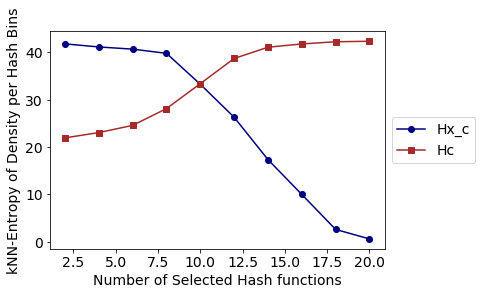

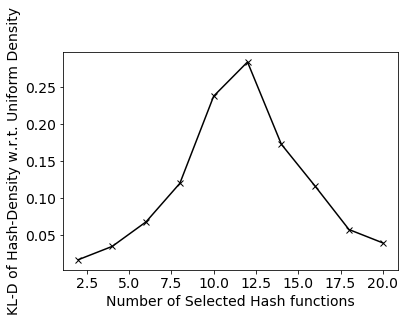

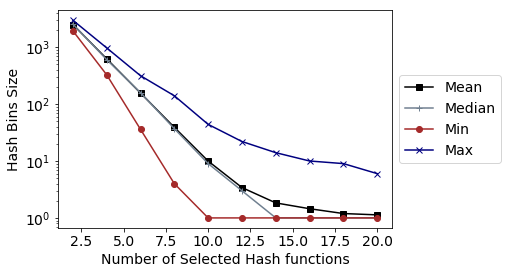

Time to compute visuals of hashcodes was 11.33567500114441s.


array([[False,  True,  True, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False]])

In [5]:
import hashcode_model_for_te as hmte
importlib.reload(hmte)

hash_model_obj = hmte.HashcodeModel(
    debug=False,
    dir_path_for_saving_hash_models=dir_path_for_saving_hash_models,
)

# number of hash functions learned are more than required. One can take log of the number of samples for approx. number of hash functions
# for decicing the number of hash function for use in regularization, the generated figures are insightful.
# hash bin size,
# KL-D of Hash Density w.r.t. Uniform
# kNN entropy of Density per Hash Bins

hash_model_obj.compute_hashcodes(
    features=np.unique(sparse_features[0, :, :].todense(), axis=0),
    is_optimize=True,
    num_cores=35,
    num_hash_functions=20,
    alpha=32,
    max_num_samples_in_cluster_for_entropy_compute=300,
    max_num_samples_in_sel_cluster_for_kl_div_compute=300,
    max_num_samples_in_cluster_for_kl_div_compute=100,
    min_set_size_to_split=8,
    max_set_size_for_info_cluster_optimal=8,
    is_equal_split=True,
    visualize_quality_of_hashcodes=True,
    model_name='ST0',
)

/v/campus/ny/cs/aiml_build/sahigarg/venv_artifactory/senv/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/ms/dist/python/PROJ/dask/2.9.1/lib/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(10000, 20) (10000,)
ST0
 % of positive labels=50.0
 % of non-zero features=100.0

hashing ...
/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n10000k20t50
(10000, 20) (10000, 20)
100%|████████████████████████████████| 300/300 [01:07<00:00,  4.42it/s, best loss: 0.7583815184483167]
ST0
 % of positive labels=50.0
 % of non-zero features=100.0
 {'bagging_fraction': 0.1, 'bagging_freq': 3, 'boosting': 'gbdt', 'device_type': 'cpu', 'feature_fraction': 0.05, 'is_unbalance': True, 'lambda_l1': 10.0, 'lambda_l2': 10.0, 'learning_rate': 0.6, 'max_depth': 5, 'metric': '', 'min_data_in_leaf': 30, 'neg_bagging_fraction': 1.0, 'num_leaves': 30, 'num_threads': 1, 'objective': 'binary', 'path_smooth': 0.1, 'pos_bagging_fraction': 1.0, 'seed': 0, 'tree_learner': 'serial', 'verbose': -1}


/ms/dist/python/PROJ/matplotlib/3.0.2-py37/exec/lib/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


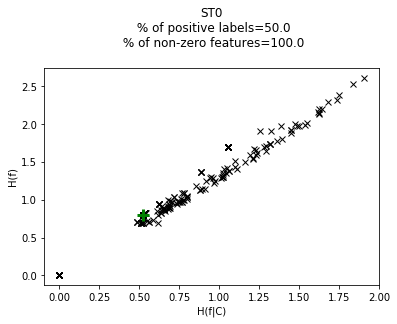

(300,) (300,)


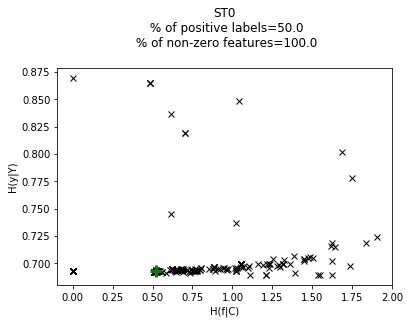

(300,) (300,)


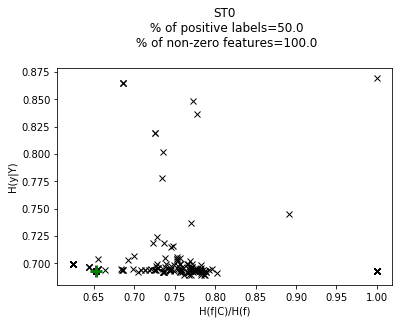

ST0: 0.16+-0.16


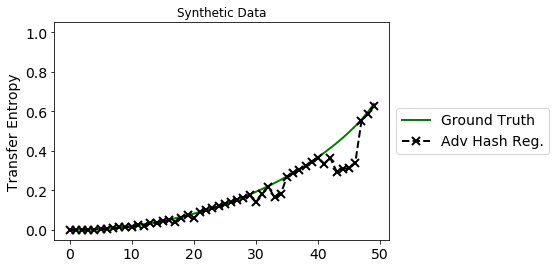

(10000, 20) (10000,)
ST0
 % of positive labels=50.0
 % of non-zero features=100.0

hashing ...
/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n10000k20t50
(10000, 20) (10000, 20)
100%|████████████████████████████████| 300/300 [01:12<00:00,  4.12it/s, best loss: 0.7409824503889906]
ST0
 % of positive labels=50.0
 % of non-zero features=100.0
 {'bagging_fraction': 0.3, 'bagging_freq': 10, 'boosting': 'gbdt', 'device_type': 'cpu', 'feature_fraction': 0.05, 'is_unbalance': False, 'lambda_l1': 10.0, 'lambda_l2': 10.0, 'learning_rate': 0.6, 'max_depth': 10, 'metric': '', 'min_data_in_leaf': 30, 'neg_bagging_fraction': 0.05, 'num_leaves': 100, 'num_threads': 1, 'objective': 'binary', 'path_smooth': 0.1, 'pos_bagging_fraction': 0.05, 'seed': 1, 'tree_learner': 'serial', 'verbose': -1}


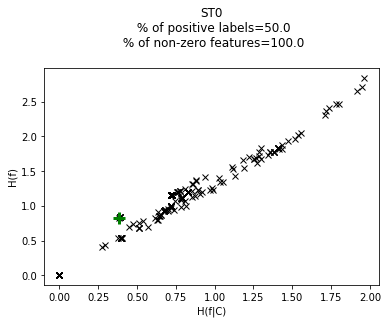

(300,) (300,)


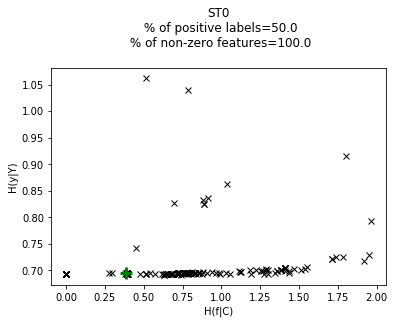

(300,) (300,)


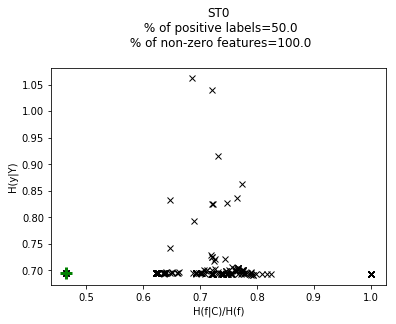

ST0: 0.17+-0.17


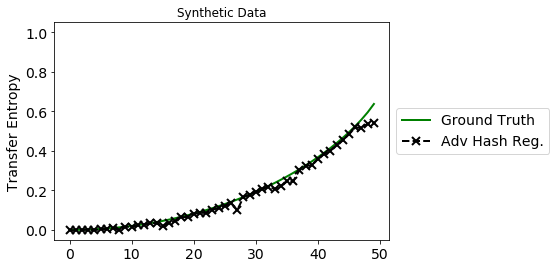

(10000, 20) (10000,)
ST0
 % of positive labels=50.0
 % of non-zero features=100.0

hashing ...
/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n10000k20t50
(10000, 20) (10000, 20)
100%|████████████████████████████████| 300/300 [01:14<00:00,  4.04it/s, best loss: 0.7610686919525224]
ST0
 % of positive labels=50.0
 % of non-zero features=100.0
 {'bagging_fraction': 0.1, 'bagging_freq': 5, 'boosting': 'gbdt', 'device_type': 'cpu', 'feature_fraction': 0.05, 'is_unbalance': False, 'lambda_l1': 1.0, 'lambda_l2': 1.0, 'learning_rate': 1.0, 'max_depth': 10, 'metric': '', 'min_data_in_leaf': 30, 'neg_bagging_fraction': 0.3, 'num_leaves': 30, 'num_threads': 1, 'objective': 'binary', 'path_smooth': 1.0, 'pos_bagging_fraction': 0.3, 'seed': 2, 'tree_learner': 'serial', 'verbose': -1}


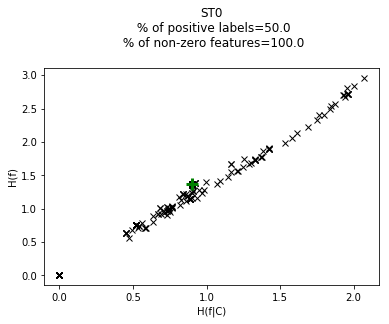

(300,) (300,)


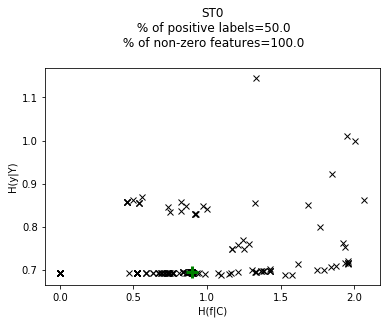

(300,) (300,)


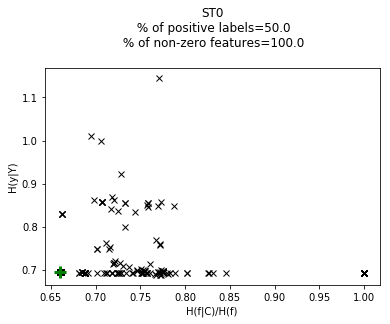

ST0: 0.18+-0.18


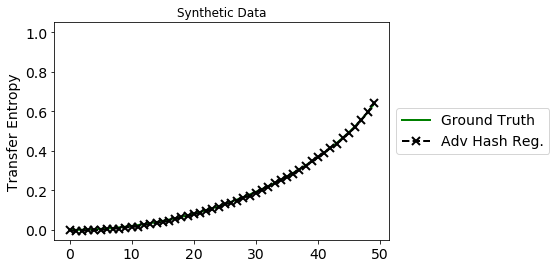

(10000, 20) (10000,)
ST0
 % of positive labels=50.0
 % of non-zero features=100.0

hashing ...
/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n10000k20t50
(10000, 20) (10000, 20)
100%|████████████████████████████████| 300/300 [01:04<00:00,  4.64it/s, best loss: 0.7346805619104667]
ST0
 % of positive labels=50.0
 % of non-zero features=100.0
 {'bagging_fraction': 0.1, 'bagging_freq': 5, 'boosting': 'gbdt', 'device_type': 'cpu', 'feature_fraction': 0.1, 'is_unbalance': True, 'lambda_l1': 10.0, 'lambda_l2': 10.0, 'learning_rate': 1.0, 'max_depth': 5, 'metric': '', 'min_data_in_leaf': 100, 'neg_bagging_fraction': 0.05, 'num_leaves': 30, 'num_threads': 1, 'objective': 'binary', 'path_smooth': 10.0, 'pos_bagging_fraction': 0.05, 'seed': 3, 'tree_learner': 'serial', 'verbose': -1}


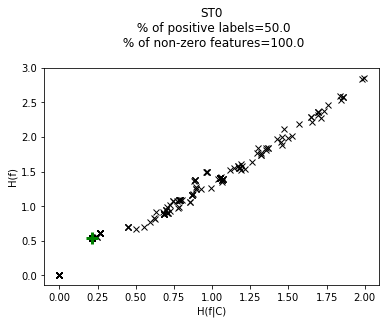

(300,) (300,)


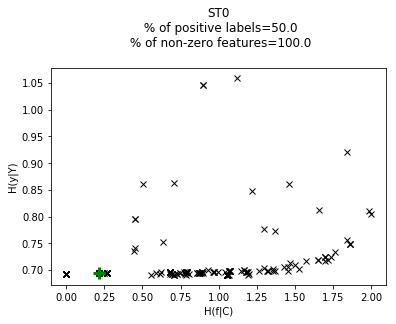

(300,) (300,)


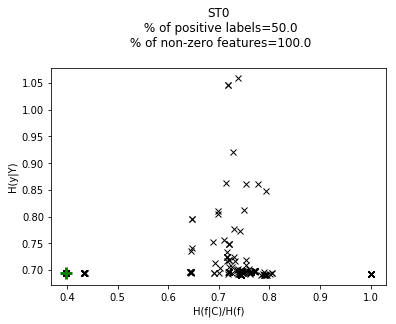

ST0: 0.18+-0.18


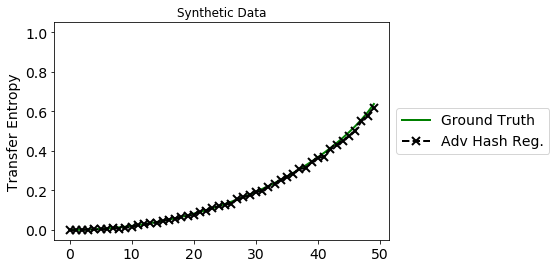

(10000, 20) (10000,)
ST0
 % of positive labels=50.0
 % of non-zero features=100.0

hashing ...
/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n10000k20t50
(10000, 20) (10000, 20)
100%|████████████████████████████████| 300/300 [01:05<00:00,  4.60it/s, best loss: 0.7521916109730723]
ST0
 % of positive labels=50.0
 % of non-zero features=100.0
 {'bagging_fraction': 0.1, 'bagging_freq': 3, 'boosting': 'gbdt', 'device_type': 'cpu', 'feature_fraction': 0.05, 'is_unbalance': False, 'lambda_l1': 1.0, 'lambda_l2': 10.0, 'learning_rate': 0.6, 'max_depth': 5, 'metric': '', 'min_data_in_leaf': 30, 'neg_bagging_fraction': 1.0, 'num_leaves': 30, 'num_threads': 1, 'objective': 'binary', 'path_smooth': 10.0, 'pos_bagging_fraction': 1.0, 'seed': 4, 'tree_learner': 'serial', 'verbose': -1}


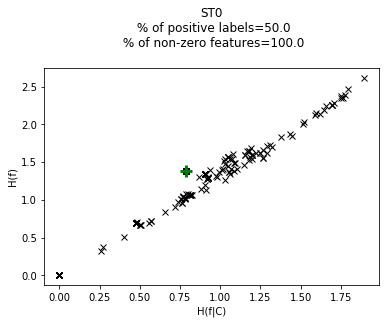

(300,) (300,)


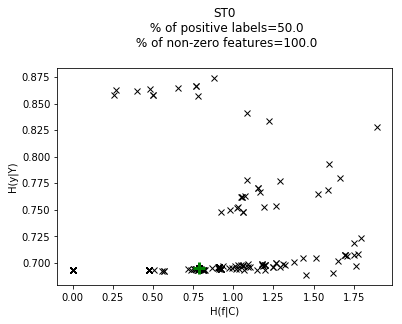

(300,) (300,)


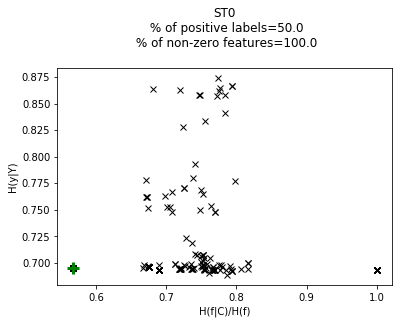

ST0: 0.17+-0.17


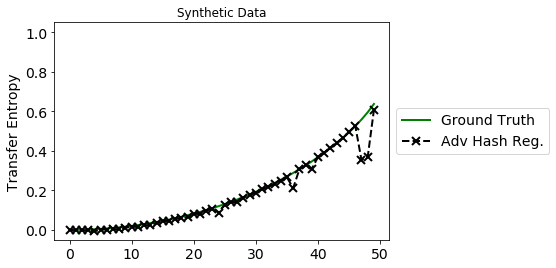

(10000, 20) (10000,)
ST0
 % of positive labels=50.0
 % of non-zero features=100.0

hashing ...
/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n10000k20t50
(10000, 20) (10000, 20)
100%|█████████████████████████████████| 300/300 [01:06<00:00,  4.50it/s, best loss: 0.746238265100744]
ST0
 % of positive labels=50.0
 % of non-zero features=100.0
 {'bagging_fraction': 1.0, 'bagging_freq': 10, 'boosting': 'gbdt', 'device_type': 'cpu', 'feature_fraction': 0.05, 'is_unbalance': False, 'lambda_l1': 10.0, 'lambda_l2': 10.0, 'learning_rate': 0.6, 'max_depth': 3, 'metric': '', 'min_data_in_leaf': 30, 'neg_bagging_fraction': 0.05, 'num_leaves': 100, 'num_threads': 1, 'objective': 'binary', 'path_smooth': 0.0, 'pos_bagging_fraction': 0.05, 'seed': 5, 'tree_learner': 'serial', 'verbose': -1}


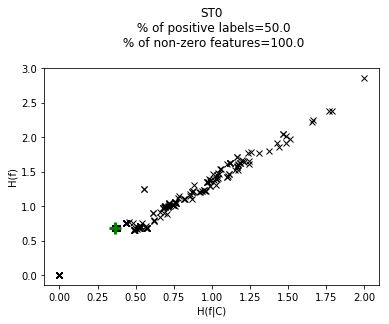

(300,) (300,)


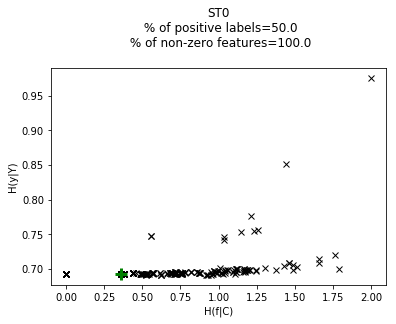

(300,) (300,)


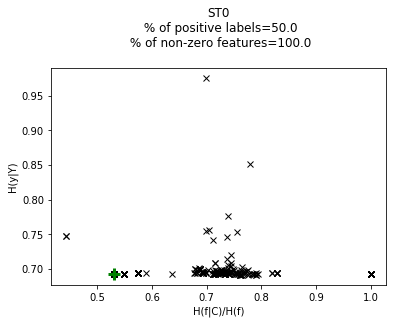

ST0: 0.14+-0.15


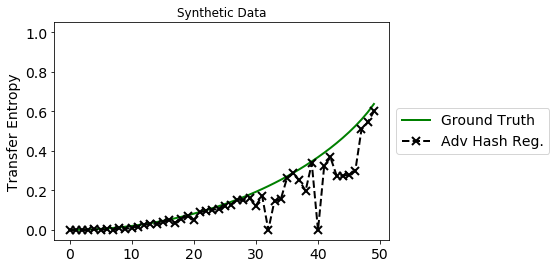

(10000, 20) (10000,)
ST0
 % of positive labels=50.0
 % of non-zero features=100.0

hashing ...
/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n10000k20t50
(10000, 20) (10000, 20)
100%|████████████████████████████████| 300/300 [00:58<00:00,  5.15it/s, best loss: 0.7477057928880415]
ST0
 % of positive labels=50.0
 % of non-zero features=100.0
 {'bagging_fraction': 0.1, 'bagging_freq': 10, 'boosting': 'gbdt', 'device_type': 'cpu', 'feature_fraction': 0.05, 'is_unbalance': False, 'lambda_l1': 10.0, 'lambda_l2': 3.0, 'learning_rate': 0.6, 'max_depth': 3, 'metric': '', 'min_data_in_leaf': 30, 'neg_bagging_fraction': 0.05, 'num_leaves': 100, 'num_threads': 1, 'objective': 'binary', 'path_smooth': 10.0, 'pos_bagging_fraction': 0.05, 'seed': 6, 'tree_learner': 'serial', 'verbose': -1}


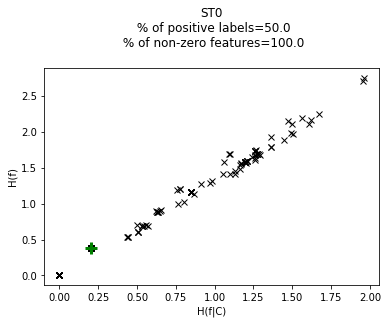

(300,) (300,)


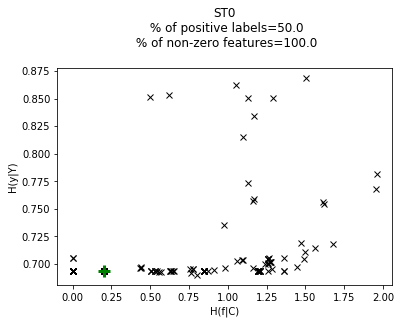

(300,) (300,)


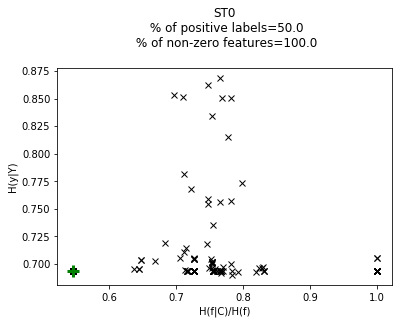

ST0: 0.18+-0.17


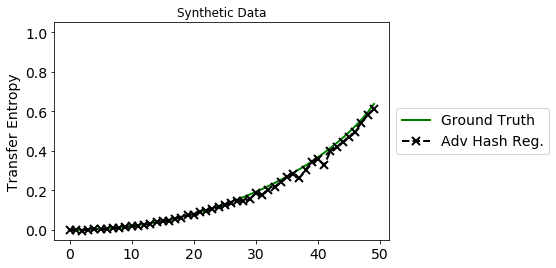

(10000, 20) (10000,)
ST0
 % of positive labels=50.0
 % of non-zero features=100.0

hashing ...
/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n10000k20t50
(10000, 20) (10000, 20)
100%|████████████████████████████████| 300/300 [01:01<00:00,  4.86it/s, best loss: 0.7542241461294801]
ST0
 % of positive labels=50.0
 % of non-zero features=100.0
 {'bagging_fraction': 0.1, 'bagging_freq': 3, 'boosting': 'gbdt', 'device_type': 'cpu', 'feature_fraction': 0.1, 'is_unbalance': True, 'lambda_l1': 10.0, 'lambda_l2': 10.0, 'learning_rate': 0.6, 'max_depth': 5, 'metric': '', 'min_data_in_leaf': 100, 'neg_bagging_fraction': 1.0, 'num_leaves': 100, 'num_threads': 1, 'objective': 'binary', 'path_smooth': 0.0, 'pos_bagging_fraction': 1.0, 'seed': 7, 'tree_learner': 'serial', 'verbose': -1}


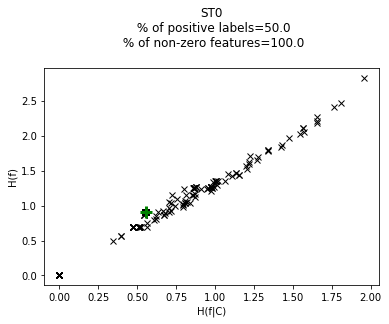

(300,) (300,)


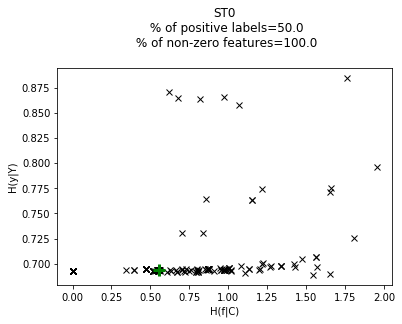

(300,) (300,)


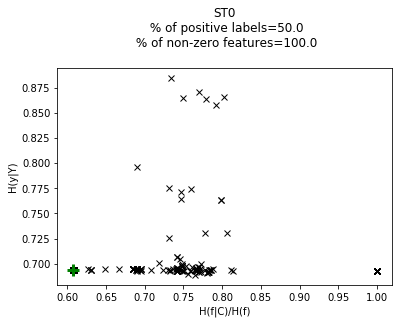

ST0: 0.18+-0.18


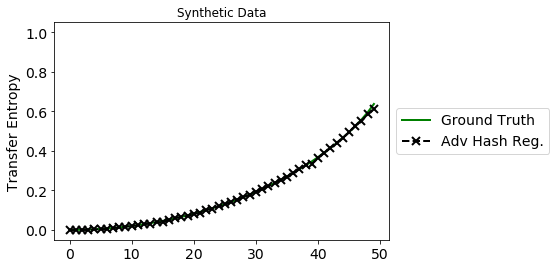

(10000, 20) (10000,)
ST0
 % of positive labels=50.0
 % of non-zero features=100.0

hashing ...
/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n10000k20t50
(10000, 20) (10000, 20)
100%|████████████████████████████████| 300/300 [00:57<00:00,  5.19it/s, best loss: 0.7481197411628364]
ST0
 % of positive labels=50.0
 % of non-zero features=100.0
 {'bagging_fraction': 0.05, 'bagging_freq': 10, 'boosting': 'gbdt', 'device_type': 'cpu', 'feature_fraction': 0.05, 'is_unbalance': True, 'lambda_l1': 10.0, 'lambda_l2': 10.0, 'learning_rate': 0.6, 'max_depth': 10, 'metric': '', 'min_data_in_leaf': 30, 'neg_bagging_fraction': 1.0, 'num_leaves': 100, 'num_threads': 1, 'objective': 'binary', 'path_smooth': 10.0, 'pos_bagging_fraction': 1.0, 'seed': 8, 'tree_learner': 'serial', 'verbose': -1}


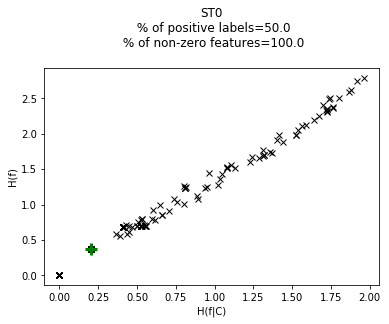

(300,) (300,)


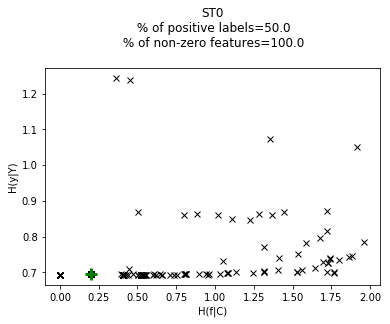

(300,) (300,)


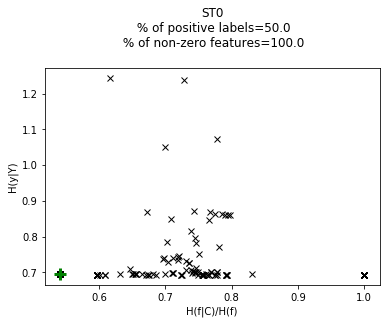

ST0: 0.17+-0.17


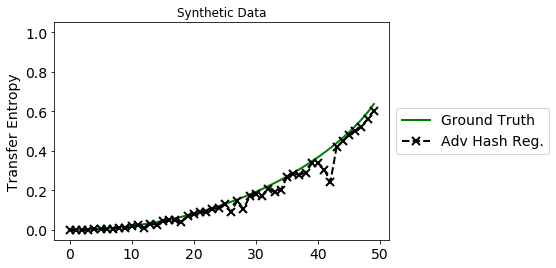

(10000, 20) (10000,)
ST0
 % of positive labels=50.0
 % of non-zero features=100.0

hashing ...
/v/campus/ny/cs/aiml_build/sahigarg/synthetic_data_hash_models_n10000k20t50
(10000, 20) (10000, 20)
100%|████████████████████████████████| 300/300 [00:59<00:00,  5.02it/s, best loss: 0.7547775238932807]
ST0
 % of positive labels=50.0
 % of non-zero features=100.0
 {'bagging_fraction': 0.05, 'bagging_freq': 10, 'boosting': 'gbdt', 'device_type': 'cpu', 'feature_fraction': 0.05, 'is_unbalance': False, 'lambda_l1': 10.0, 'lambda_l2': 3.0, 'learning_rate': 1.0, 'max_depth': 5, 'metric': '', 'min_data_in_leaf': 30, 'neg_bagging_fraction': 0.3, 'num_leaves': 30, 'num_threads': 1, 'objective': 'binary', 'path_smooth': 0.0, 'pos_bagging_fraction': 0.3, 'seed': 9, 'tree_learner': 'serial', 'verbose': -1}


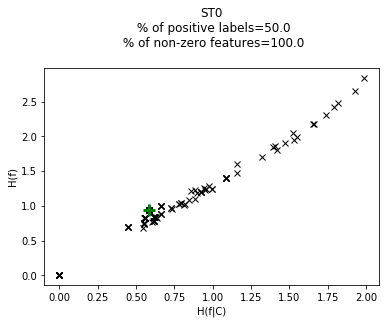

(300,) (300,)


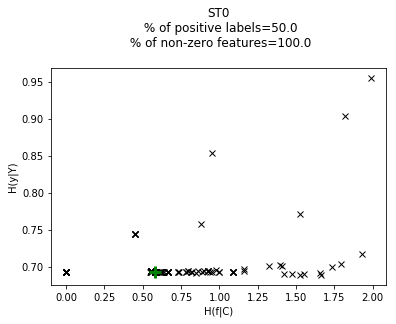

(300,) (300,)


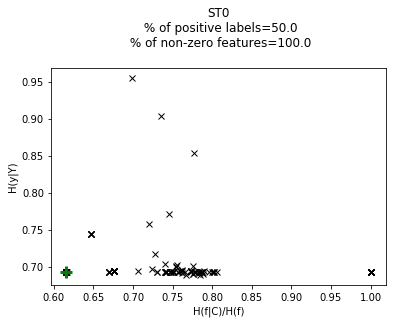

ST0: 0.19+-0.18


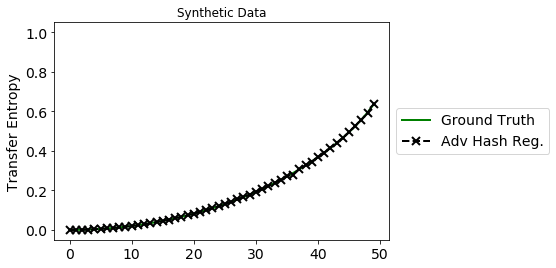

In [6]:
import transfer_entropy_estimator_gbm_clf as teecr
importlib.reload(teecr)

# value for hyper=parameter lambda_entropy_predictor_cond_hashcodes can be tuned,
# as per the generated figures on H(f), H(f|C), H(y|Y). 
# H(f) is entropy of predictions,
# H(y|Y) is conditional entropy for self-timeseries, 
# H(f|C) is conditional entropy of predictions given hashcode bins.        
        
# 10 trials are performed, plotting results for each
for seed in range(10):

    obj = teecr.TransferEntropyGBMClf(
        time_lag=features_dim,
        num_hash_funcs=10,
        dir_path_for_saving_hash_models=dir_path_for_saving_hash_models,
        num_max_evals_for_tuning=300,
        lambda_entropy_predictor_cond_hashcodes=0.1,
        seed=seed,
    )

    obj.num_time_series = num_time_series
    obj.ticker_names = np.array(['ST'+str(i) for i in range(num_time_series)])
    obj.features = sparse_features
    obj.labels = sparse_labels

    te_gbm_hash_reg, _ = obj.compute_transfer_entropy_for_i(i=0)

    fontsize = 14
    plt.close()
    plt.rcParams["font.family"] = "Times New Roman"
    plt.plot(te, '-', color='green', label='Ground Truth', ms=8, lw=2, mew=2)
    plt.plot(te_gbm_hash_reg, 'x--', color='black', label='Adv Hash Reg.', ms=8, lw=2, mew=2)
    plt.ylabel('Transfer Entropy', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylim(-0.05, 1.05)
    plt.title('Synthetic Data')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontsize)
    plt.show()